In [1]:
!pip3 install scikit-learn tqdm catboost optuna xgboost ipywidgets imblearn

In [17]:
import pandas as pd
import sklearn
import numpy as np
import random
import os
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner
from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold


In [18]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed=42
seed_everything(seed) # Seed 고정

In [19]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [20]:
def category_all(df_train, df_test):
    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
    'customer_idx',
    'lead_owner',
    ]
    for i in label_columns:
        df_train[i] = df_train[i].astype('category')
        df_test[i] = df_test[i].astype('category')
    return df_train, df_test    


def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""
    
    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

        
def manage_label_encoding(df_train, df_test):
    tmp = len(df_train)
    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
   'customer_idx',
   'lead_owner',
    ]
    
    df_all = pd.concat([df_train[label_columns], df_test[label_columns]])

    for col in label_columns:
        df_all[col] = label_encoding(df_all[col])
    
    for col in label_columns:  
        df_train[col] = df_all.iloc[: tmp][col]
        df_test[col] = df_all.iloc[tmp :][col]

    return df_train, df_test

def preprocessing(df_train, df_test):
    df_train.drop_duplicates(keep='first', inplace=True)
    df_train.reset_index(inplace=True)
    df_train.drop('index',inplace=True, axis=1)
    df_test_id_temp = df_test['id'].copy()
    df_all = pd.concat([df_train,df_test.drop('id',axis=1)])
    df_all.drop('customer_country.1',axis=1,inplace=True)
    df_all.id_strategic_ver.fillna(0., inplace=True)
    df_all.it_strategic_ver.fillna(0., inplace=True)
    df_all.idit_strategic_ver.fillna(0., inplace=True)
    df_all.business_subarea.fillna('NAN', inplace=True)
    df_all.com_reg_ver_win_rate.fillna(0,inplace=True)
    df_all['customer_type'] = df_all['customer_type'].replace({
        'End-Customer':'End Customer'
    })
    df_all.customer_type.fillna('NAN',inplace=True)
    df_all.historical_existing_cnt.fillna(0, inplace=True)
    
    df_all.product_subcategory.fillna('NAN', inplace=True)
    
    df_all.product_modelname.fillna('NAN', inplace=True)

    df_all['expected_timeline'] = df_all['expected_timeline'].replace({
        'less_than_3_months': 'less than 3 months',
        'being followed up': 'being followed up.',
        'less than 6 months': '3 months ~ 6 months',
        '3_months_~_6_months' : '3 months ~ 6 months'
    })

    df_all.expected_timeline.fillna('NAN',inplace=True)
    df_all.ver_win_rate_x.fillna(0,inplace=True)
    df_all.ver_win_ratio_per_bu.fillna(0,inplace=True)
    df_all.business_area.fillna('NAN',inplace=True)
    df_all.customer_job.fillna('NAN', inplace=True)
    df_all.product_category.fillna('NAN', inplace=True)
    
    #처리못한부분
    #customer_country
    df_all.customer_country.fillna('NAN', inplace=True)
    #inquiry_type
    df_all.inquiry_type.fillna('NAN', inplace=True)

    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
    ]
    
    ###############################
    #detect special char and to lower
    for i in label_columns:
        df_all[i] = df_all[i].str.lower()
        df_all[i] = df_all[i].str.replace(pat=r'[^\w]', repl=r'', regex=True)
        
    #to int
    df_all['id_strategic_ver'] = df_all['id_strategic_ver'].astype('int64')
    df_all['it_strategic_ver'] = df_all['it_strategic_ver'].astype('int64')
    df_all['idit_strategic_ver'] = df_all['idit_strategic_ver'].astype('int64')
    df_all['lead_desc_length'] = df_all['lead_desc_length'].astype('int64')
    df_all['historical_existing_cnt'] = df_all['historical_existing_cnt'].astype('int64')

    #seperate
    tmp_len = len(df_train)
    df_train = df_all.iloc[: tmp_len ]
    df_test = df_all.iloc[tmp_len :]
    df_test = pd.concat([df_test,df_test_id_temp],axis=1)
    
    #RobustScaler
    robustScaler = RobustScaler()
    df_train['ver_win_rate_x'] = robustScaler.fit_transform(df_train[['ver_win_rate_x']])
    df_test['ver_win_rate_x'] = robustScaler.transform(df_test[['ver_win_rate_x']])
    robustScaler = RobustScaler()
    df_train['ver_win_ratio_per_bu'] = robustScaler.fit_transform(df_train[['ver_win_ratio_per_bu']])
    df_test['ver_win_ratio_per_bu'] = robustScaler.transform(df_test[['ver_win_ratio_per_bu']])
    ##############################
    
    return df_train, df_test


df_train, df_test = preprocessing(df_train, df_test)
df_train, df_test = category_all(df_train, df_test)
rate = ((len(df_train)-sum(df_train['is_converted']))/sum(df_train['is_converted']))
x_train, y_train = df_train.drop("is_converted",axis=1), df_train["is_converted"]

In [21]:
categorical_features = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
   'customer_idx',
   'lead_owner',
    ]

S_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

all_train_pool = []
all_val_pool = []
all_y_val = []

for train_idx, val_idx in S_kfold.split(x_train, list(y_train)):
    tmp_x_train, tmp_x_val = x_train.iloc[train_idx], x_train.iloc[val_idx]
    tmp_y_train, tmp_y_val = y_train[train_idx], y_train[val_idx]
    train_pool = Pool(data=tmp_x_train, label=tmp_y_train, cat_features=categorical_features)
    val_pool = Pool(data=tmp_x_val, label=tmp_y_val, cat_features=categorical_features)
    all_train_pool.append(train_pool)
    all_val_pool.append(val_pool)
    all_y_val.append(list(tmp_y_val))

In [22]:
def objective(trial):
    params = {
        'iterations':trial.suggest_int("iterations", 10000, 50000),
        'learning_rate' : trial.suggest_uniform('learning_rate',0.001, 1),
        'reg_lambda': trial.suggest_uniform('reg_lambda',10,100),
        'random_strength': trial.suggest_uniform('random_strength',40,100),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,50),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        'bagging_temperature' :trial.suggest_uniform('bagging_temperature', 0, 1),
        'verbose':False,
        'random_state':seed,
    }
    
    #score = []
    tmp_score = []
    for train_pool, val_pool, y_true in zip(all_train_pool, all_val_pool, all_y_val):
        clf = CatBoostClassifier(**params,
                                 scale_pos_weight=rate, 
                                 loss_function='Logloss',
                                 eval_metric='F1',
                                 task_type="GPU",
                                 devices='0',
                                 early_stopping_rounds=100
                                )
        clf.fit(train_pool, eval_set=val_pool)
        
        y_pred = clf.predict(val_pool)
        y_pred = [False if i=='False' else True for i in y_pred]
        tmp_score.append(f1_score(y_true,y_pred,labels=[True, False]))
    tmp_score = np.mean(tmp_score)
    return tmp_score

# Hyperparameter Tuning
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed), pruner=SuccessiveHalvingPruner())
study.optimize(objective, n_trials=None)

[I 2024-02-13 11:15:08,558] A new study created in memory with name: no-name-5d316ebd-c8e5-4afa-909f-88d5cd95a4d1
[I 2024-02-13 11:15:29,966] Trial 0 finished with value: 0.7660358222204603 and parameters: {'iterations': 24981, 'learning_rate': 0.9507635921035062, 'reg_lambda': 75.87945476302646, 'random_strength': 75.91950905182219, 'min_data_in_leaf': 8, 'leaf_estimation_iterations': 3, 'bagging_temperature': 0.05808361216819946}. Best is trial 0 with value: 0.7660358222204603.
[I 2024-02-13 11:15:55,540] Trial 1 finished with value: 0.7737143172627997 and parameters: {'iterations': 44647, 'learning_rate': 0.6015138967314656, 'reg_lambda': 73.7265320016441, 'random_strength': 41.23506965774815, 'min_data_in_leaf': 49, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.21233911067827616}. Best is trial 1 with value: 0.7737143172627997.
[I 2024-02-13 11:16:28,270] Trial 2 finished with value: 0.7679795201939081 and parameters: {'iterations': 17273, 'learning_rate': 0.1842211053

[I 2024-02-13 11:26:10,089] Trial 22 finished with value: 0.767713224323559 and parameters: {'iterations': 41784, 'learning_rate': 0.3777085258776885, 'reg_lambda': 29.819022578383546, 'random_strength': 77.95782356573909, 'min_data_in_leaf': 30, 'leaf_estimation_iterations': 1, 'bagging_temperature': 0.5157802234584801}. Best is trial 5 with value: 0.7795491170978122.
[I 2024-02-13 11:26:57,283] Trial 23 finished with value: 0.7698602268449648 and parameters: {'iterations': 46527, 'learning_rate': 0.10193099262858901, 'reg_lambda': 43.195648536489976, 'random_strength': 54.03816058807694, 'min_data_in_leaf': 43, 'leaf_estimation_iterations': 5, 'bagging_temperature': 0.27796012484631183}. Best is trial 5 with value: 0.7795491170978122.
[I 2024-02-13 11:27:19,574] Trial 24 finished with value: 0.769335162699255 and parameters: {'iterations': 38669, 'learning_rate': 0.5631418831045854, 'reg_lambda': 18.3746538560084, 'random_strength': 62.7153885380208, 'min_data_in_leaf': 37, 'leaf_est

[I 2024-02-13 11:38:28,180] Trial 44 finished with value: 0.766470941012243 and parameters: {'iterations': 10153, 'learning_rate': 0.3340426020863717, 'reg_lambda': 63.559002767813936, 'random_strength': 70.81611948646723, 'min_data_in_leaf': 31, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.5606511044279935}. Best is trial 5 with value: 0.7795491170978122.
[I 2024-02-13 11:38:54,051] Trial 45 finished with value: 0.7639926075047607 and parameters: {'iterations': 21189, 'learning_rate': 0.49450962532349685, 'reg_lambda': 55.280277634508884, 'random_strength': 66.09236869076086, 'min_data_in_leaf': 1, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.7204461120188871}. Best is trial 5 with value: 0.7795491170978122.
[I 2024-02-13 11:39:28,017] Trial 46 finished with value: 0.7792887871498373 and parameters: {'iterations': 48022, 'learning_rate': 0.4180110570462964, 'reg_lambda': 74.61008131589017, 'random_strength': 57.929966668413016, 'min_data_in_leaf': 46, 'leaf

[I 2024-02-13 11:49:46,438] Trial 66 finished with value: 0.7799414986810742 and parameters: {'iterations': 37500, 'learning_rate': 0.2357962312014021, 'reg_lambda': 15.09859503212284, 'random_strength': 54.18320057803414, 'min_data_in_leaf': 48, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.3737443484470021}. Best is trial 66 with value: 0.7799414986810742.
[I 2024-02-13 11:50:20,390] Trial 67 finished with value: 0.778637198050488 and parameters: {'iterations': 36071, 'learning_rate': 0.2342809189618766, 'reg_lambda': 15.785255104946817, 'random_strength': 53.167930028346206, 'min_data_in_leaf': 48, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.3631828622426759}. Best is trial 66 with value: 0.7799414986810742.
[I 2024-02-13 11:51:15,565] Trial 68 finished with value: 0.769286917991512 and parameters: {'iterations': 35888, 'learning_rate': 0.07828480347786818, 'reg_lambda': 16.905443304709284, 'random_strength': 56.3188672616057, 'min_data_in_leaf': 50, 'lea

[I 2024-02-13 12:02:40,933] Trial 88 finished with value: 0.779402425992713 and parameters: {'iterations': 49204, 'learning_rate': 0.3256822069086586, 'reg_lambda': 13.84811017909121, 'random_strength': 55.517216788708225, 'min_data_in_leaf': 49, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.07035666758961825}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 12:03:13,944] Trial 89 finished with value: 0.7851180599791174 and parameters: {'iterations': 49052, 'learning_rate': 0.32514463329622967, 'reg_lambda': 14.049243133374132, 'random_strength': 55.301249261832396, 'min_data_in_leaf': 50, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.08154064394048438}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 12:03:45,208] Trial 90 finished with value: 0.7744255859649105 and parameters: {'iterations': 45972, 'learning_rate': 0.2837492364172052, 'reg_lambda': 18.195487250807734, 'random_strength': 55.15660582232818, 'min_data_in_leaf': 49,

[I 2024-02-13 12:13:36,539] Trial 110 finished with value: 0.7603278891501194 and parameters: {'iterations': 43644, 'learning_rate': 0.7644703504221517, 'reg_lambda': 12.56526944089844, 'random_strength': 54.285782745781184, 'min_data_in_leaf': 43, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.3786653561304043}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 12:14:07,725] Trial 111 finished with value: 0.7790597795546763 and parameters: {'iterations': 41522, 'learning_rate': 0.33089955736224597, 'reg_lambda': 19.9399251128972, 'random_strength': 56.150981656102054, 'min_data_in_leaf': 50, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.11147383213739259}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 12:14:35,253] Trial 112 finished with value: 0.7717632369142027 and parameters: {'iterations': 41985, 'learning_rate': 0.31393042020184314, 'reg_lambda': 15.475591298203296, 'random_strength': 52.766262012401626, 'min_data_in_leaf': 

[I 2024-02-13 12:26:06,321] Trial 132 finished with value: 0.7746613731803866 and parameters: {'iterations': 40501, 'learning_rate': 0.20186973867784191, 'reg_lambda': 18.558611463776156, 'random_strength': 51.28305610179387, 'min_data_in_leaf': 47, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.1606689092398613}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 12:26:35,299] Trial 133 finished with value: 0.7772241410736163 and parameters: {'iterations': 45352, 'learning_rate': 0.3172747507579035, 'reg_lambda': 21.270750421866016, 'random_strength': 57.36482396631561, 'min_data_in_leaf': 45, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.11714145298638129}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 12:27:08,909] Trial 134 finished with value: 0.7797961690471309 and parameters: {'iterations': 41878, 'learning_rate': 0.2503669554360496, 'reg_lambda': 24.296000339843275, 'random_strength': 59.54405537207241, 'min_data_in_leaf': 4

[I 2024-02-13 12:37:46,493] Trial 154 finished with value: 0.7756325485425991 and parameters: {'iterations': 43276, 'learning_rate': 0.23593467931599202, 'reg_lambda': 12.074394652189689, 'random_strength': 56.84912183429085, 'min_data_in_leaf': 47, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.2857724227192327}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 12:38:15,262] Trial 155 finished with value: 0.7752473159426431 and parameters: {'iterations': 44381, 'learning_rate': 0.30427479178889366, 'reg_lambda': 10.250609984953094, 'random_strength': 49.61645912371397, 'min_data_in_leaf': 50, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.3392742542081063}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 12:38:44,544] Trial 156 finished with value: 0.7756116424654986 and parameters: {'iterations': 38731, 'learning_rate': 0.3394311332883207, 'reg_lambda': 20.01593960371853, 'random_strength': 52.51077729548824, 'min_data_in_leaf': 46,

[I 2024-02-13 12:50:06,505] Trial 176 finished with value: 0.7718602524370883 and parameters: {'iterations': 40047, 'learning_rate': 0.16736672196911245, 'reg_lambda': 14.910361794632578, 'random_strength': 60.87909111216052, 'min_data_in_leaf': 47, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.27181032214513273}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 12:50:42,165] Trial 177 finished with value: 0.7742254647939002 and parameters: {'iterations': 42370, 'learning_rate': 0.2003863479606598, 'reg_lambda': 11.861809806155335, 'random_strength': 68.67269537258557, 'min_data_in_leaf': 43, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.3290438863613006}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 12:51:13,346] Trial 178 finished with value: 0.775868661557106 and parameters: {'iterations': 45255, 'learning_rate': 0.3023192287409116, 'reg_lambda': 18.92385344539462, 'random_strength': 55.89277049105981, 'min_data_in_leaf': 49,

[I 2024-02-13 13:01:38,670] Trial 198 finished with value: 0.7743231494135363 and parameters: {'iterations': 29290, 'learning_rate': 0.20798228269300154, 'reg_lambda': 20.468624212643498, 'random_strength': 52.58861751891682, 'min_data_in_leaf': 46, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.3527868903720408}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 13:02:10,753] Trial 199 finished with value: 0.7767418125139656 and parameters: {'iterations': 27035, 'learning_rate': 0.2688727093889281, 'reg_lambda': 17.659344268823283, 'random_strength': 51.38899442276863, 'min_data_in_leaf': 47, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.3004297587606779}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 13:02:43,897] Trial 200 finished with value: 0.7814045180389787 and parameters: {'iterations': 29855, 'learning_rate': 0.3033298506145177, 'reg_lambda': 14.149231108087804, 'random_strength': 54.47292414563753, 'min_data_in_leaf': 48

[I 2024-02-13 13:12:47,421] Trial 220 finished with value: 0.7479242917474423 and parameters: {'iterations': 29563, 'learning_rate': 0.839787583361937, 'reg_lambda': 24.425205168325437, 'random_strength': 63.8730920059134, 'min_data_in_leaf': 48, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.44901885885633475}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 13:13:16,459] Trial 221 finished with value: 0.7679816434523224 and parameters: {'iterations': 27695, 'learning_rate': 0.28575281242775197, 'reg_lambda': 19.45321729076483, 'random_strength': 59.439670225396576, 'min_data_in_leaf': 49, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.3855143583579401}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 13:13:46,834] Trial 222 finished with value: 0.7725022757802087 and parameters: {'iterations': 25794, 'learning_rate': 0.2684022915476649, 'reg_lambda': 22.193510685607926, 'random_strength': 60.72667784782686, 'min_data_in_leaf': 46,

[I 2024-02-13 13:24:31,713] Trial 242 finished with value: 0.7735771503062214 and parameters: {'iterations': 37671, 'learning_rate': 0.21789342733597813, 'reg_lambda': 17.85976675637382, 'random_strength': 61.692652130206746, 'min_data_in_leaf': 46, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.18298085563910438}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 13:25:01,943] Trial 243 finished with value: 0.7771498130476445 and parameters: {'iterations': 34861, 'learning_rate': 0.25055759905039193, 'reg_lambda': 13.764941965904837, 'random_strength': 59.45024164343129, 'min_data_in_leaf': 47, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.21277428731832768}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 13:25:35,826] Trial 244 finished with value: 0.7817135691528259 and parameters: {'iterations': 41497, 'learning_rate': 0.22114486905594563, 'reg_lambda': 15.818553130184517, 'random_strength': 55.90555417139011, 'min_data_in_leaf': 

[I 2024-02-13 13:36:28,342] Trial 264 finished with value: 0.7644071933017058 and parameters: {'iterations': 24388, 'learning_rate': 0.2354984322777185, 'reg_lambda': 92.26525916866433, 'random_strength': 63.47891833450469, 'min_data_in_leaf': 35, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.3259734257601884}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 13:37:01,951] Trial 265 finished with value: 0.780526603304381 and parameters: {'iterations': 42899, 'learning_rate': 0.26601821212043403, 'reg_lambda': 14.180652203287314, 'random_strength': 53.80504887118294, 'min_data_in_leaf': 44, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.2802011228836862}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 13:37:23,359] Trial 266 finished with value: 0.7577547156863826 and parameters: {'iterations': 43090, 'learning_rate': 0.9740748205528323, 'reg_lambda': 13.628545761540646, 'random_strength': 53.85581761469099, 'min_data_in_leaf': 45, 

[I 2024-02-13 13:49:06,574] Trial 286 finished with value: 0.7763757972404255 and parameters: {'iterations': 44713, 'learning_rate': 0.22239206883723114, 'reg_lambda': 62.68797911310254, 'random_strength': 54.29251183792142, 'min_data_in_leaf': 49, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.10387820973635517}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 13:49:47,760] Trial 287 finished with value: 0.7741750784851615 and parameters: {'iterations': 43556, 'learning_rate': 0.13961436291258744, 'reg_lambda': 15.874631756113049, 'random_strength': 55.68776367161199, 'min_data_in_leaf': 47, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.16064876355027072}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 13:50:16,911] Trial 288 finished with value: 0.774512780185173 and parameters: {'iterations': 41901, 'learning_rate': 0.2933394176108703, 'reg_lambda': 17.33746812801705, 'random_strength': 58.88304612073937, 'min_data_in_leaf': 50

[I 2024-02-13 14:01:01,636] Trial 308 finished with value: 0.7750545839681233 and parameters: {'iterations': 23949, 'learning_rate': 0.20439399646461745, 'reg_lambda': 14.928499135717766, 'random_strength': 51.44621038227316, 'min_data_in_leaf': 35, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.23575883978753284}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 14:01:34,582] Trial 309 finished with value: 0.7796152855224018 and parameters: {'iterations': 24787, 'learning_rate': 0.2483642580831582, 'reg_lambda': 10.164407179709782, 'random_strength': 55.83989264738953, 'min_data_in_leaf': 36, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.21140507050636648}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 14:02:06,873] Trial 310 finished with value: 0.7785434548251277 and parameters: {'iterations': 25839, 'learning_rate': 0.22376768801696623, 'reg_lambda': 19.504669235620607, 'random_strength': 49.329115599602346, 'min_data_in_leaf'

[I 2024-02-13 14:13:21,821] Trial 330 finished with value: 0.781609196503062 and parameters: {'iterations': 44133, 'learning_rate': 0.3080566024063959, 'reg_lambda': 17.274950619843505, 'random_strength': 57.81172233279786, 'min_data_in_leaf': 47, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.3309964250316834}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 14:13:53,202] Trial 331 finished with value: 0.7795993620205555 and parameters: {'iterations': 43919, 'learning_rate': 0.3216855329280538, 'reg_lambda': 13.425573463453588, 'random_strength': 57.44729312828595, 'min_data_in_leaf': 46, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.3434180666679166}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 14:14:22,842] Trial 332 finished with value: 0.7736606312493011 and parameters: {'iterations': 39073, 'learning_rate': 0.3028303035287545, 'reg_lambda': 16.937709417938578, 'random_strength': 58.48971892138041, 'min_data_in_leaf': 47, 

[I 2024-02-13 14:24:11,089] Trial 352 finished with value: 0.7735392521516642 and parameters: {'iterations': 44854, 'learning_rate': 0.25882880446500683, 'reg_lambda': 19.461787716142723, 'random_strength': 50.77708725499244, 'min_data_in_leaf': 47, 'leaf_estimation_iterations': 3, 'bagging_temperature': 0.24955038468504723}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 14:24:42,260] Trial 353 finished with value: 0.7737118505428203 and parameters: {'iterations': 46179, 'learning_rate': 0.35090564035573263, 'reg_lambda': 28.66936883413846, 'random_strength': 48.861698564380426, 'min_data_in_leaf': 9, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.22494525393793474}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 14:25:14,283] Trial 354 finished with value: 0.7761123907031325 and parameters: {'iterations': 45099, 'learning_rate': 0.2756715868363182, 'reg_lambda': 16.32039098746101, 'random_strength': 47.216918292929215, 'min_data_in_leaf': 1

[I 2024-02-13 14:34:56,998] Trial 374 finished with value: 0.7807736943590055 and parameters: {'iterations': 27914, 'learning_rate': 0.3278789815603944, 'reg_lambda': 13.518896606574017, 'random_strength': 51.539597197122475, 'min_data_in_leaf': 49, 'leaf_estimation_iterations': 5, 'bagging_temperature': 0.42473044648199726}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 14:35:31,895] Trial 375 finished with value: 0.7782196143419673 and parameters: {'iterations': 24905, 'learning_rate': 0.22930270498137573, 'reg_lambda': 16.59762166037767, 'random_strength': 52.457782302169456, 'min_data_in_leaf': 47, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.1954043158472786}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 14:36:01,422] Trial 376 finished with value: 0.7739479797380724 and parameters: {'iterations': 44324, 'learning_rate': 0.3062405705158728, 'reg_lambda': 12.20735060183476, 'random_strength': 92.65714947515212, 'min_data_in_leaf': 30

[I 2024-02-13 14:45:52,668] Trial 396 finished with value: 0.7833994683925789 and parameters: {'iterations': 27760, 'learning_rate': 0.2676491352701164, 'reg_lambda': 14.373036272404482, 'random_strength': 51.004002969103276, 'min_data_in_leaf': 37, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.1779944409303283}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 14:46:14,498] Trial 397 finished with value: 0.768931666958889 and parameters: {'iterations': 27687, 'learning_rate': 0.4790370013551648, 'reg_lambda': 11.60412889524626, 'random_strength': 50.4613452872781, 'min_data_in_leaf': 37, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.17143040564922132}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 14:46:38,679] Trial 398 finished with value: 0.7768123014698219 and parameters: {'iterations': 27006, 'learning_rate': 0.4180192040202999, 'reg_lambda': 14.035156420423627, 'random_strength': 78.93634634358648, 'min_data_in_leaf': 38, 'l

[I 2024-02-13 14:55:57,690] Trial 418 finished with value: 0.7698656705569095 and parameters: {'iterations': 28392, 'learning_rate': 0.34261493058051173, 'reg_lambda': 17.043181215622067, 'random_strength': 42.03909294398619, 'min_data_in_leaf': 49, 'leaf_estimation_iterations': 5, 'bagging_temperature': 0.4807616835920041}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 14:56:23,223] Trial 419 finished with value: 0.7721128030797179 and parameters: {'iterations': 30378, 'learning_rate': 0.28228098586374134, 'reg_lambda': 14.916065555561559, 'random_strength': 45.74492949062121, 'min_data_in_leaf': 38, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.26069034143609504}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 14:56:52,778] Trial 420 finished with value: 0.7796955249805695 and parameters: {'iterations': 27923, 'learning_rate': 0.2382911414918607, 'reg_lambda': 10.223526410522252, 'random_strength': 48.72611322135926, 'min_data_in_leaf': 48

[I 2024-02-13 15:06:38,864] Trial 440 finished with value: 0.7831929574476881 and parameters: {'iterations': 30808, 'learning_rate': 0.31817604685085155, 'reg_lambda': 13.142343406312914, 'random_strength': 47.39171850597435, 'min_data_in_leaf': 22, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.212088724804175}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 15:07:08,235] Trial 441 finished with value: 0.7815592772943178 and parameters: {'iterations': 30978, 'learning_rate': 0.2984179083817094, 'reg_lambda': 12.531563653161559, 'random_strength': 45.334672522004134, 'min_data_in_leaf': 35, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.23838088674890656}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 15:07:36,580] Trial 442 finished with value: 0.7774231073031219 and parameters: {'iterations': 15322, 'learning_rate': 0.31814582797397956, 'reg_lambda': 11.387536724708106, 'random_strength': 47.21829046374336, 'min_data_in_leaf': 19

[I 2024-02-13 15:17:02,677] Trial 462 finished with value: 0.7732238440766638 and parameters: {'iterations': 30891, 'learning_rate': 0.30675796968816815, 'reg_lambda': 18.18589888116137, 'random_strength': 70.58787476509922, 'min_data_in_leaf': 22, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.6459294075074014}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 15:17:33,141] Trial 463 finished with value: 0.7724459427843714 and parameters: {'iterations': 23213, 'learning_rate': 0.28568300333279373, 'reg_lambda': 20.897228540433264, 'random_strength': 46.91815291554151, 'min_data_in_leaf': 38, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.24850367560714304}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 15:18:04,109] Trial 464 finished with value: 0.7818837659068325 and parameters: {'iterations': 29684, 'learning_rate': 0.32567507408126933, 'reg_lambda': 15.987490140038725, 'random_strength': 42.8128073184483, 'min_data_in_leaf': 2

[I 2024-02-13 15:27:37,112] Trial 484 finished with value: 0.7827685224887869 and parameters: {'iterations': 48785, 'learning_rate': 0.3606681751483165, 'reg_lambda': 20.477161587137637, 'random_strength': 80.24176539488514, 'min_data_in_leaf': 47, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.35539679503029004}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 15:28:03,976] Trial 485 finished with value: 0.7759499742110825 and parameters: {'iterations': 49685, 'learning_rate': 0.3290721954062371, 'reg_lambda': 20.156445992132564, 'random_strength': 81.36506350661936, 'min_data_in_leaf': 47, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.30275998841450086}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 15:28:28,553] Trial 486 finished with value: 0.7699724874341562 and parameters: {'iterations': 47223, 'learning_rate': 0.41890402856746395, 'reg_lambda': 21.759879721164516, 'random_strength': 79.96210369696928, 'min_data_in_leaf': 

[I 2024-02-13 15:38:57,174] Trial 506 finished with value: 0.7855259585787061 and parameters: {'iterations': 27908, 'learning_rate': 0.2927959025510728, 'reg_lambda': 99.85386031989941, 'random_strength': 55.50465499412637, 'min_data_in_leaf': 48, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.3859582539793022}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 15:39:31,690] Trial 507 finished with value: 0.7732518102106696 and parameters: {'iterations': 27925, 'learning_rate': 0.2599508541386608, 'reg_lambda': 97.18655064277078, 'random_strength': 57.189249787168364, 'min_data_in_leaf': 47, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.3835335566800345}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 15:40:02,714] Trial 508 finished with value: 0.7723608447117132 and parameters: {'iterations': 28923, 'learning_rate': 0.227683866851602, 'reg_lambda': 10.322962078010251, 'random_strength': 56.47274355248836, 'min_data_in_leaf': 49, '

[I 2024-02-13 15:51:09,468] Trial 528 finished with value: 0.7722018637533049 and parameters: {'iterations': 30352, 'learning_rate': 0.2968825600728681, 'reg_lambda': 14.39257645851473, 'random_strength': 55.90569011134382, 'min_data_in_leaf': 37, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.3688822278872098}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 15:51:37,379] Trial 529 finished with value: 0.7737466651799 and parameters: {'iterations': 26303, 'learning_rate': 0.33665846413521744, 'reg_lambda': 24.187189131963876, 'random_strength': 46.90214947925394, 'min_data_in_leaf': 48, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.3175512337194041}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 15:52:11,497] Trial 530 finished with value: 0.7831990841719072 and parameters: {'iterations': 26845, 'learning_rate': 0.24204643277565527, 'reg_lambda': 15.99128533149605, 'random_strength': 58.478400530814085, 'min_data_in_leaf': 35, '

[I 2024-02-13 16:03:03,182] Trial 550 finished with value: 0.7805510512059183 and parameters: {'iterations': 46785, 'learning_rate': 0.35759645520638317, 'reg_lambda': 18.79884430085043, 'random_strength': 47.593591528440996, 'min_data_in_leaf': 46, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.1893277169496108}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 16:03:37,680] Trial 551 finished with value: 0.778896367956095 and parameters: {'iterations': 27079, 'learning_rate': 0.2580934173155321, 'reg_lambda': 13.77485526977177, 'random_strength': 60.52320484781009, 'min_data_in_leaf': 49, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.24972258198156003}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 16:04:07,219] Trial 552 finished with value: 0.779709490828336 and parameters: {'iterations': 25411, 'learning_rate': 0.3886824164977762, 'reg_lambda': 32.696531387691024, 'random_strength': 56.49326579423865, 'min_data_in_leaf': 33, 

[I 2024-02-13 16:14:52,897] Trial 572 finished with value: 0.7752937199235468 and parameters: {'iterations': 24573, 'learning_rate': 0.23687615513705382, 'reg_lambda': 90.14862263265316, 'random_strength': 52.32487277575232, 'min_data_in_leaf': 45, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.23474470213837145}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 16:15:18,841] Trial 573 finished with value: 0.7632915483984151 and parameters: {'iterations': 22450, 'learning_rate': 0.3198616060089565, 'reg_lambda': 80.95938758135912, 'random_strength': 54.83941807890222, 'min_data_in_leaf': 35, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.35930925454486645}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 16:15:47,243] Trial 574 finished with value: 0.7725435644776968 and parameters: {'iterations': 38257, 'learning_rate': 0.26948853827723107, 'reg_lambda': 18.965439962647114, 'random_strength': 48.82805472667539, 'min_data_in_leaf': 4

[I 2024-02-13 16:26:03,039] Trial 594 finished with value: 0.777868654805035 and parameters: {'iterations': 37027, 'learning_rate': 0.2767440345086571, 'reg_lambda': 86.04335095249644, 'random_strength': 56.59547937047546, 'min_data_in_leaf': 30, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.19340738230420515}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 16:26:39,800] Trial 595 finished with value: 0.7776519407594701 and parameters: {'iterations': 24211, 'learning_rate': 0.21609460731655666, 'reg_lambda': 15.527509905227085, 'random_strength': 93.89100920040141, 'min_data_in_leaf': 47, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.32075404887886444}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 16:27:09,511] Trial 596 finished with value: 0.7677676737630201 and parameters: {'iterations': 25093, 'learning_rate': 0.3283842624044072, 'reg_lambda': 79.32069663458863, 'random_strength': 53.16310127461474, 'min_data_in_leaf': 50,

[I 2024-02-13 16:38:23,735] Trial 616 finished with value: 0.7793697509632598 and parameters: {'iterations': 48456, 'learning_rate': 0.19552365652658035, 'reg_lambda': 10.146354955455624, 'random_strength': 56.10000684258016, 'min_data_in_leaf': 50, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.18759564476679733}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 16:39:05,233] Trial 617 finished with value: 0.7792351438612436 and parameters: {'iterations': 47483, 'learning_rate': 0.20602528497520523, 'reg_lambda': 99.13796223988246, 'random_strength': 54.206702636046295, 'min_data_in_leaf': 50, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.14732351518287556}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 16:39:41,807] Trial 618 finished with value: 0.7792638714695035 and parameters: {'iterations': 49888, 'learning_rate': 0.20180007315524637, 'reg_lambda': 13.925556872292404, 'random_strength': 57.09304167401083, 'min_data_in_leaf'

[I 2024-02-13 16:51:29,781] Trial 638 finished with value: 0.7746056943731388 and parameters: {'iterations': 23811, 'learning_rate': 0.2406968316426301, 'reg_lambda': 13.75946304256216, 'random_strength': 53.88172132749078, 'min_data_in_leaf': 50, 'leaf_estimation_iterations': 5, 'bagging_temperature': 0.18430507971959606}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 16:51:55,363] Trial 639 finished with value: 0.7730309208295019 and parameters: {'iterations': 26491, 'learning_rate': 0.5071109256688601, 'reg_lambda': 15.820799443866356, 'random_strength': 58.27731044048605, 'min_data_in_leaf': 48, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.21334606642279116}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 16:52:36,036] Trial 640 finished with value: 0.7724426847171812 and parameters: {'iterations': 48113, 'learning_rate': 0.16289833616731472, 'reg_lambda': 77.2526322932855, 'random_strength': 53.7780326630026, 'min_data_in_leaf': 36, '

[I 2024-02-13 17:05:24,457] Trial 660 finished with value: 0.7783470143505203 and parameters: {'iterations': 49888, 'learning_rate': 0.21151868426704426, 'reg_lambda': 50.4215481700759, 'random_strength': 52.10710740162895, 'min_data_in_leaf': 48, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.26322505113201083}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 17:06:02,116] Trial 661 finished with value: 0.7817600492987344 and parameters: {'iterations': 46619, 'learning_rate': 0.20944812698695248, 'reg_lambda': 10.096230056353173, 'random_strength': 54.18461712308497, 'min_data_in_leaf': 47, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.24120034232084547}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 17:06:45,572] Trial 662 finished with value: 0.7815649705060829 and parameters: {'iterations': 48653, 'learning_rate': 0.16317682866621153, 'reg_lambda': 13.187909940777764, 'random_strength': 50.786399499416795, 'min_data_in_leaf':

[I 2024-02-13 17:17:30,339] Trial 682 finished with value: 0.7827869087519537 and parameters: {'iterations': 25278, 'learning_rate': 0.22869577810555436, 'reg_lambda': 13.025880973505165, 'random_strength': 52.04309854984297, 'min_data_in_leaf': 50, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.28374569644076914}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 17:17:50,807] Trial 683 finished with value: 0.7628205099485041 and parameters: {'iterations': 27321, 'learning_rate': 0.5903729926142024, 'reg_lambda': 15.015652868817352, 'random_strength': 55.19251195599545, 'min_data_in_leaf': 42, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.2493562173951797}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 17:18:20,363] Trial 684 finished with value: 0.7761488987038059 and parameters: {'iterations': 48272, 'learning_rate': 0.3305057582660305, 'reg_lambda': 12.033720164348797, 'random_strength': 49.57915513228416, 'min_data_in_leaf': 20

[I 2024-02-13 17:28:51,626] Trial 704 finished with value: 0.7811317730059287 and parameters: {'iterations': 27504, 'learning_rate': 0.26148631170684367, 'reg_lambda': 14.559925779335316, 'random_strength': 45.24066032456744, 'min_data_in_leaf': 33, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.21279458912283916}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 17:29:26,153] Trial 705 finished with value: 0.7730345297410517 and parameters: {'iterations': 29493, 'learning_rate': 0.2275532567462824, 'reg_lambda': 18.493191474940247, 'random_strength': 50.11911289166402, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.18734729603272074}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 17:30:00,747] Trial 706 finished with value: 0.7822510089713893 and parameters: {'iterations': 43612, 'learning_rate': 0.29172471621882445, 'reg_lambda': 12.483588946678147, 'random_strength': 52.99901261297923, 'min_data_in_leaf':

[I 2024-02-13 17:40:39,898] Trial 726 finished with value: 0.7820438053038781 and parameters: {'iterations': 22961, 'learning_rate': 0.21597524841761578, 'reg_lambda': 13.259231626597474, 'random_strength': 52.090545502830764, 'min_data_in_leaf': 37, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.31097474812332465}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 17:41:14,334] Trial 727 finished with value: 0.7791172482020277 and parameters: {'iterations': 24255, 'learning_rate': 0.29748056876751083, 'reg_lambda': 91.2112544235398, 'random_strength': 41.82498721131236, 'min_data_in_leaf': 48, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.19580601367646824}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 17:41:48,503] Trial 728 finished with value: 0.7829067744881466 and parameters: {'iterations': 31235, 'learning_rate': 0.24702969128920016, 'reg_lambda': 15.897585583479987, 'random_strength': 47.76017597451949, 'min_data_in_leaf':

[I 2024-02-13 17:52:20,572] Trial 748 finished with value: 0.7785276598838624 and parameters: {'iterations': 26994, 'learning_rate': 0.13811051609015879, 'reg_lambda': 25.56633301764148, 'random_strength': 54.274252562923394, 'min_data_in_leaf': 45, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.23319928858628552}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 17:52:49,650] Trial 749 finished with value: 0.7747666370258897 and parameters: {'iterations': 24562, 'learning_rate': 0.36992022848197803, 'reg_lambda': 21.676467604243292, 'random_strength': 43.66135553953636, 'min_data_in_leaf': 47, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.2728434479710618}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 17:53:27,738] Trial 750 finished with value: 0.773928454817108 and parameters: {'iterations': 26267, 'learning_rate': 0.2219469912014875, 'reg_lambda': 69.06477687537955, 'random_strength': 98.73153724375055, 'min_data_in_leaf': 47

[I 2024-02-13 18:03:57,018] Trial 770 finished with value: 0.7569071173942981 and parameters: {'iterations': 22372, 'learning_rate': 0.7867860174027438, 'reg_lambda': 83.03706409593048, 'random_strength': 58.52097112870548, 'min_data_in_leaf': 34, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.2613159485608418}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 18:04:35,260] Trial 771 finished with value: 0.7765601447801561 and parameters: {'iterations': 48318, 'learning_rate': 0.1708647310879212, 'reg_lambda': 13.054040155976232, 'random_strength': 48.555985732333696, 'min_data_in_leaf': 42, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.22528462568223753}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 18:05:11,564] Trial 772 finished with value: 0.7858229986701771 and parameters: {'iterations': 23877, 'learning_rate': 0.2766293210741414, 'reg_lambda': 16.46957946886462, 'random_strength': 56.26484105971987, 'min_data_in_leaf': 49,

[I 2024-02-13 18:14:49,608] Trial 792 finished with value: 0.773853978514348 and parameters: {'iterations': 49123, 'learning_rate': 0.31318588177275714, 'reg_lambda': 11.561050216306855, 'random_strength': 47.14057361056487, 'min_data_in_leaf': 47, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.18830337860909296}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 18:15:26,256] Trial 793 finished with value: 0.7803830748715529 and parameters: {'iterations': 39368, 'learning_rate': 0.22448572284364265, 'reg_lambda': 15.410466292291115, 'random_strength': 50.83696622464584, 'min_data_in_leaf': 50, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.23819723934505174}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 18:15:59,388] Trial 794 finished with value: 0.7719945069408697 and parameters: {'iterations': 47062, 'learning_rate': 0.25331978030895885, 'reg_lambda': 94.9847844888245, 'random_strength': 53.05027833147717, 'min_data_in_leaf': 4

[I 2024-02-13 18:26:39,867] Trial 814 finished with value: 0.7720690526802708 and parameters: {'iterations': 42075, 'learning_rate': 0.3225595199793799, 'reg_lambda': 18.776298080662364, 'random_strength': 42.6003939100359, 'min_data_in_leaf': 48, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.20481514359338937}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 18:27:15,986] Trial 815 finished with value: 0.7807875524841669 and parameters: {'iterations': 40777, 'learning_rate': 0.2071025841654474, 'reg_lambda': 15.567354303495703, 'random_strength': 46.65496370814383, 'min_data_in_leaf': 28, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.2365783042112468}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 18:27:48,018] Trial 816 finished with value: 0.7774395525345078 and parameters: {'iterations': 40039, 'learning_rate': 0.3014510993712809, 'reg_lambda': 17.23923002800131, 'random_strength': 44.8825168409598, 'min_data_in_leaf': 49, '

[I 2024-02-13 18:39:07,848] Trial 836 finished with value: 0.7778954544643921 and parameters: {'iterations': 47598, 'learning_rate': 0.2000593523378775, 'reg_lambda': 26.902654288950316, 'random_strength': 47.324142736254345, 'min_data_in_leaf': 45, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.2716082883156579}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 18:39:46,026] Trial 837 finished with value: 0.7806178196040625 and parameters: {'iterations': 47158, 'learning_rate': 0.22883370606729458, 'reg_lambda': 22.055339492002453, 'random_strength': 49.3855537269951, 'min_data_in_leaf': 44, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.2992531722000174}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 18:40:19,098] Trial 838 finished with value: 0.7776033034309782 and parameters: {'iterations': 47994, 'learning_rate': 0.24680503321550104, 'reg_lambda': 21.362143012602886, 'random_strength': 48.26921578162273, 'min_data_in_leaf': 4

[I 2024-02-13 18:53:07,361] Trial 858 finished with value: 0.7712435464208738 and parameters: {'iterations': 48588, 'learning_rate': 0.12199619282571081, 'reg_lambda': 23.42375832627129, 'random_strength': 45.45300697974215, 'min_data_in_leaf': 49, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.2623101767539657}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 18:53:45,364] Trial 859 finished with value: 0.7776851457850965 and parameters: {'iterations': 49779, 'learning_rate': 0.1849244554616616, 'reg_lambda': 44.464810331714325, 'random_strength': 43.98142860942575, 'min_data_in_leaf': 49, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.2372647347133778}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 18:54:21,358] Trial 860 finished with value: 0.7751013243217562 and parameters: {'iterations': 47542, 'learning_rate': 0.19309157903888605, 'reg_lambda': 18.916003936913235, 'random_strength': 47.701976938947006, 'min_data_in_leaf': 4

[I 2024-02-13 19:07:55,938] Trial 880 finished with value: 0.7782259789085672 and parameters: {'iterations': 48263, 'learning_rate': 0.1951533416548873, 'reg_lambda': 18.919210359215352, 'random_strength': 49.78499170889704, 'min_data_in_leaf': 49, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.21787599315361905}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 19:08:41,858] Trial 881 finished with value: 0.7755324021149721 and parameters: {'iterations': 46432, 'learning_rate': 0.1587585376219382, 'reg_lambda': 89.2158789827212, 'random_strength': 48.777229816842315, 'min_data_in_leaf': 49, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.9232065279008046}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 19:09:16,355] Trial 882 finished with value: 0.7767326859990374 and parameters: {'iterations': 47120, 'learning_rate': 0.24593775266159948, 'reg_lambda': 17.71676148995024, 'random_strength': 47.39332775149569, 'min_data_in_leaf': 47,

[I 2024-02-13 19:19:49,764] Trial 902 finished with value: 0.7724583598514014 and parameters: {'iterations': 41962, 'learning_rate': 0.2466100031638493, 'reg_lambda': 22.660357741078567, 'random_strength': 46.242839498707326, 'min_data_in_leaf': 50, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.2360823123887859}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 19:20:21,029] Trial 903 finished with value: 0.7746316758164165 and parameters: {'iterations': 47934, 'learning_rate': 0.2234759280077195, 'reg_lambda': 16.974615999677823, 'random_strength': 51.06482738189629, 'min_data_in_leaf': 48, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.3077666256352749}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 19:20:48,912] Trial 904 finished with value: 0.7727919219810663 and parameters: {'iterations': 40890, 'learning_rate': 0.32999220006364693, 'reg_lambda': 20.20990005314142, 'random_strength': 48.77663037425148, 'min_data_in_leaf': 49

[I 2024-02-13 19:31:49,540] Trial 924 finished with value: 0.7800847414144034 and parameters: {'iterations': 49898, 'learning_rate': 0.2282965818743097, 'reg_lambda': 94.65509265034332, 'random_strength': 51.90074480761135, 'min_data_in_leaf': 45, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.24337568224256342}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 19:32:15,000] Trial 925 finished with value: 0.7650017946914552 and parameters: {'iterations': 49304, 'learning_rate': 0.4964276486196014, 'reg_lambda': 91.92156618104242, 'random_strength': 51.549553246958084, 'min_data_in_leaf': 43, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.2777938576984777}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 19:32:55,282] Trial 926 finished with value: 0.7785373275299785 and parameters: {'iterations': 48795, 'learning_rate': 0.19895176733991704, 'reg_lambda': 96.54706411028268, 'random_strength': 52.70904765570449, 'min_data_in_leaf': 43,

[I 2024-02-13 19:45:23,614] Trial 946 finished with value: 0.7781996175247077 and parameters: {'iterations': 48670, 'learning_rate': 0.2085524959291519, 'reg_lambda': 94.24185572321693, 'random_strength': 52.711337264971554, 'min_data_in_leaf': 48, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.4818278045345673}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 19:45:53,652] Trial 947 finished with value: 0.7745631960809158 and parameters: {'iterations': 47522, 'learning_rate': 0.24202958112042286, 'reg_lambda': 19.640396214988463, 'random_strength': 44.179492608192085, 'min_data_in_leaf': 50, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.22806311385858802}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 19:46:14,859] Trial 948 finished with value: 0.7483590797999633 and parameters: {'iterations': 48838, 'learning_rate': 0.9391515174426424, 'reg_lambda': 92.454930702525, 'random_strength': 55.53426448989268, 'min_data_in_leaf': 49,

[I 2024-02-13 19:57:51,748] Trial 968 finished with value: 0.7741094404477835 and parameters: {'iterations': 39736, 'learning_rate': 0.17433546233975739, 'reg_lambda': 17.15945967567853, 'random_strength': 46.446258117606654, 'min_data_in_leaf': 30, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.3298103074337961}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 19:58:22,067] Trial 969 finished with value: 0.772830994708796 and parameters: {'iterations': 25441, 'learning_rate': 0.3490443456089022, 'reg_lambda': 96.19291012001032, 'random_strength': 41.290035761650614, 'min_data_in_leaf': 46, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.3005760035971059}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 19:58:55,850] Trial 970 finished with value: 0.7741815151898404 and parameters: {'iterations': 49124, 'learning_rate': 0.2487266561661291, 'reg_lambda': 81.71939124683227, 'random_strength': 55.436238153068054, 'min_data_in_leaf': 48,

[I 2024-02-13 20:10:01,103] Trial 990 finished with value: 0.7636891644491705 and parameters: {'iterations': 24547, 'learning_rate': 0.2017407939627538, 'reg_lambda': 98.39978712629201, 'random_strength': 56.05545390556262, 'min_data_in_leaf': 49, 'leaf_estimation_iterations': 4, 'bagging_temperature': 0.2804361785958703}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 20:10:32,277] Trial 991 finished with value: 0.7756993780371055 and parameters: {'iterations': 48744, 'learning_rate': 0.23098389520399987, 'reg_lambda': 14.177515658514553, 'random_strength': 46.74098783118302, 'min_data_in_leaf': 50, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.226410425826216}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 20:11:00,411] Trial 992 finished with value: 0.7746960150282766 and parameters: {'iterations': 48406, 'learning_rate': 0.2776215748630591, 'reg_lambda': 17.524476636167538, 'random_strength': 44.514747231799056, 'min_data_in_leaf': 47, 

[I 2024-02-13 20:22:02,678] Trial 1012 finished with value: 0.7727855628856434 and parameters: {'iterations': 17107, 'learning_rate': 0.3336826783288366, 'reg_lambda': 12.97595235267939, 'random_strength': 55.79101698205199, 'min_data_in_leaf': 45, 'leaf_estimation_iterations': 1, 'bagging_temperature': 0.25236480954014096}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 20:22:32,869] Trial 1013 finished with value: 0.7735202398912396 and parameters: {'iterations': 49965, 'learning_rate': 0.2836590275406272, 'reg_lambda': 19.285592004111834, 'random_strength': 58.49525232511559, 'min_data_in_leaf': 50, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.35240678882480253}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 20:22:59,948] Trial 1014 finished with value: 0.7770196887441032 and parameters: {'iterations': 26522, 'learning_rate': 0.3688322986703046, 'reg_lambda': 14.563927360180639, 'random_strength': 50.512601294946876, 'min_data_in_leaf':

[I 2024-02-13 20:34:50,503] Trial 1034 finished with value: 0.7780707900979135 and parameters: {'iterations': 46190, 'learning_rate': 0.12095687885341389, 'reg_lambda': 15.048208393023545, 'random_strength': 50.25319518806518, 'min_data_in_leaf': 45, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.18846368166546745}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 20:35:30,796] Trial 1035 finished with value: 0.7703423251072877 and parameters: {'iterations': 47185, 'learning_rate': 0.12019988987565342, 'reg_lambda': 11.542263660834017, 'random_strength': 48.35981767494255, 'min_data_in_leaf': 46, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.1512466369846167}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 20:36:10,780] Trial 1036 finished with value: 0.7770247240170911 and parameters: {'iterations': 45422, 'learning_rate': 0.15431431992426434, 'reg_lambda': 10.052402572043793, 'random_strength': 52.10733856441096, 'min_data_in_lea

[I 2024-02-13 20:49:01,866] Trial 1056 finished with value: 0.773041790079315 and parameters: {'iterations': 47922, 'learning_rate': 0.218025567212555, 'reg_lambda': 76.14943511870679, 'random_strength': 53.48495983236896, 'min_data_in_leaf': 47, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.1624115320747661}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 20:49:34,352] Trial 1057 finished with value: 0.7775707708758874 and parameters: {'iterations': 21815, 'learning_rate': 0.25186646566981963, 'reg_lambda': 11.78448277827397, 'random_strength': 55.13523595621583, 'min_data_in_leaf': 50, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.25327778579817245}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 20:50:22,048] Trial 1058 finished with value: 0.7809323545081636 and parameters: {'iterations': 36892, 'learning_rate': 0.15266096223850745, 'reg_lambda': 50.19201668434902, 'random_strength': 46.300123302001424, 'min_data_in_leaf': 4

[I 2024-02-13 21:02:12,168] Trial 1078 finished with value: 0.7718959386355485 and parameters: {'iterations': 48559, 'learning_rate': 0.24157144302011718, 'reg_lambda': 95.98274009901694, 'random_strength': 52.63301299001323, 'min_data_in_leaf': 48, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.2524344544154981}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 21:02:44,698] Trial 1079 finished with value: 0.7737331101573073 and parameters: {'iterations': 25223, 'learning_rate': 0.2892940377947644, 'reg_lambda': 98.24864934677818, 'random_strength': 48.51866168511577, 'min_data_in_leaf': 32, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.2701894152600394}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 21:03:24,355] Trial 1080 finished with value: 0.7775775163927834 and parameters: {'iterations': 47284, 'learning_rate': 0.16428572497858032, 'reg_lambda': 16.289021530811635, 'random_strength': 42.52843268969426, 'min_data_in_leaf': 

[I 2024-02-13 21:14:35,474] Trial 1100 finished with value: 0.7598585300314409 and parameters: {'iterations': 43441, 'learning_rate': 0.6535559417355414, 'reg_lambda': 15.682482830325965, 'random_strength': 54.81904385319611, 'min_data_in_leaf': 42, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.23263880926660327}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 21:15:08,683] Trial 1101 finished with value: 0.76312740646032 and parameters: {'iterations': 41927, 'learning_rate': 0.3276120627366153, 'reg_lambda': 91.65546175215073, 'random_strength': 48.96990110390002, 'min_data_in_leaf': 47, 'leaf_estimation_iterations': 1, 'bagging_temperature': 0.2876899817840888}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 21:15:30,996] Trial 1102 finished with value: 0.7582613178816873 and parameters: {'iterations': 48555, 'learning_rate': 0.7024052555558099, 'reg_lambda': 17.079745609107484, 'random_strength': 53.17075896377939, 'min_data_in_leaf': 49,

[I 2024-02-13 21:26:35,172] Trial 1122 finished with value: 0.7791079152663223 and parameters: {'iterations': 39270, 'learning_rate': 0.2526682435553446, 'reg_lambda': 19.6269439058374, 'random_strength': 44.62898114683572, 'min_data_in_leaf': 47, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.2297113364049027}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 21:27:11,500] Trial 1123 finished with value: 0.7783384682862933 and parameters: {'iterations': 46970, 'learning_rate': 0.19769786820572294, 'reg_lambda': 16.460496863727407, 'random_strength': 59.45496976096106, 'min_data_in_leaf': 50, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.25059308596022845}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 21:27:43,802] Trial 1124 finished with value: 0.7744265185875194 and parameters: {'iterations': 29296, 'learning_rate': 0.2888504416680728, 'reg_lambda': 98.47895711036125, 'random_strength': 47.274894274716694, 'min_data_in_leaf': 

[I 2024-02-13 21:39:05,730] Trial 1144 finished with value: 0.7815983239767522 and parameters: {'iterations': 46740, 'learning_rate': 0.2562780521643032, 'reg_lambda': 13.113325819044087, 'random_strength': 45.45606597941219, 'min_data_in_leaf': 28, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.21585094608211314}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 21:39:57,925] Trial 1145 finished with value: 0.7819288802284453 and parameters: {'iterations': 41641, 'learning_rate': 0.15519841601975015, 'reg_lambda': 62.818389844625216, 'random_strength': 42.006278630526616, 'min_data_in_leaf': 33, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.23525740281383561}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 21:40:27,856] Trial 1146 finished with value: 0.7752875349226468 and parameters: {'iterations': 28090, 'learning_rate': 0.35302893182060635, 'reg_lambda': 17.005834876223965, 'random_strength': 59.22919213831464, 'min_data_in_le

[I 2024-02-13 21:51:22,204] Trial 1166 finished with value: 0.7783758254859376 and parameters: {'iterations': 26577, 'learning_rate': 0.24130417878607693, 'reg_lambda': 12.705150213375093, 'random_strength': 45.71640916986683, 'min_data_in_leaf': 45, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.19438653387545068}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 21:52:00,631] Trial 1167 finished with value: 0.7742748650769077 and parameters: {'iterations': 27823, 'learning_rate': 0.16306721109517075, 'reg_lambda': 15.146691717546503, 'random_strength': 45.999832535097035, 'min_data_in_leaf': 46, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.2452769722139913}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 21:52:36,421] Trial 1168 finished with value: 0.7763115947304591 and parameters: {'iterations': 25077, 'learning_rate': 0.19266624411950076, 'reg_lambda': 11.636735075469533, 'random_strength': 44.13990415340293, 'min_data_in_le

[I 2024-02-13 22:04:28,704] Trial 1188 finished with value: 0.7816778322323488 and parameters: {'iterations': 40576, 'learning_rate': 0.2409242399734355, 'reg_lambda': 14.01655876693796, 'random_strength': 52.81159213271642, 'min_data_in_leaf': 47, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.23349979584575703}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 22:05:05,284] Trial 1189 finished with value: 0.7794953591714675 and parameters: {'iterations': 25307, 'learning_rate': 0.1719241319039635, 'reg_lambda': 15.565592024237242, 'random_strength': 45.91584129073457, 'min_data_in_leaf': 48, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.3482552234330042}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 22:05:39,215] Trial 1190 finished with value: 0.7754886721291899 and parameters: {'iterations': 42469, 'learning_rate': 0.25932685543591305, 'reg_lambda': 11.672003365535804, 'random_strength': 47.36814346730097, 'min_data_in_leaf': 

[I 2024-02-13 22:17:06,897] Trial 1210 finished with value: 0.778200039290658 and parameters: {'iterations': 46212, 'learning_rate': 0.2345202734803098, 'reg_lambda': 16.884720542693053, 'random_strength': 51.84422978726863, 'min_data_in_leaf': 48, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.30537998255824084}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 22:17:41,722] Trial 1211 finished with value: 0.7738711045697589 and parameters: {'iterations': 28233, 'learning_rate': 0.1957028135046821, 'reg_lambda': 14.592913061671226, 'random_strength': 48.11563533135015, 'min_data_in_leaf': 33, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.23924624318478585}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 22:18:14,277] Trial 1212 finished with value: 0.7748201866588776 and parameters: {'iterations': 29245, 'learning_rate': 0.2602831574100618, 'reg_lambda': 18.95713713695489, 'random_strength': 45.160406571328664, 'min_data_in_leaf': 

[I 2024-02-13 22:29:56,642] Trial 1232 finished with value: 0.7751461976351074 and parameters: {'iterations': 35408, 'learning_rate': 0.16066458116194926, 'reg_lambda': 11.438022051184504, 'random_strength': 56.09499815617253, 'min_data_in_leaf': 47, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.08141974030749727}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 22:30:33,978] Trial 1233 finished with value: 0.7773727487825682 and parameters: {'iterations': 37429, 'learning_rate': 0.18890710480082762, 'reg_lambda': 12.9942395280328, 'random_strength': 54.98732786521614, 'min_data_in_leaf': 48, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.12997644173086306}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 22:31:08,096] Trial 1234 finished with value: 0.7758705126650316 and parameters: {'iterations': 38507, 'learning_rate': 0.1969976987171396, 'reg_lambda': 13.935561732066905, 'random_strength': 56.65810374186885, 'min_data_in_leaf'

[I 2024-02-13 22:43:00,263] Trial 1254 finished with value: 0.7778261873691162 and parameters: {'iterations': 34614, 'learning_rate': 0.19088636096146194, 'reg_lambda': 13.927846872873117, 'random_strength': 55.15245759480338, 'min_data_in_leaf': 50, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.14929883856433798}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 22:43:32,269] Trial 1255 finished with value: 0.7721719439747223 and parameters: {'iterations': 32421, 'learning_rate': 0.2732812102270275, 'reg_lambda': 16.033256830469266, 'random_strength': 57.55231229925352, 'min_data_in_leaf': 24, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.48890318616645556}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 22:44:09,242] Trial 1256 finished with value: 0.783734996599144 and parameters: {'iterations': 28102, 'learning_rate': 0.23787545225410153, 'reg_lambda': 18.57889110785043, 'random_strength': 47.43978017774085, 'min_data_in_leaf'

[I 2024-02-13 22:55:26,648] Trial 1276 finished with value: 0.7740804392780746 and parameters: {'iterations': 37283, 'learning_rate': 0.2335845626412968, 'reg_lambda': 17.035973019597478, 'random_strength': 40.26131695983551, 'min_data_in_leaf': 46, 'leaf_estimation_iterations': 2, 'bagging_temperature': 0.39835546090112117}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 22:55:59,791] Trial 1277 finished with value: 0.7755003787561959 and parameters: {'iterations': 35183, 'learning_rate': 0.21826384662228934, 'reg_lambda': 20.542019613689675, 'random_strength': 43.34969660053323, 'min_data_in_leaf': 47, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.3779634608209159}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 22:56:32,008] Trial 1278 finished with value: 0.7762435202425537 and parameters: {'iterations': 36553, 'learning_rate': 0.25337002657591107, 'reg_lambda': 25.665277619638026, 'random_strength': 43.18180629562208, 'min_data_in_leaf'

[I 2024-02-13 23:07:34,560] Trial 1298 finished with value: 0.777470777838267 and parameters: {'iterations': 38924, 'learning_rate': 0.2912799975490285, 'reg_lambda': 10.017184470505267, 'random_strength': 42.66077419486767, 'min_data_in_leaf': 29, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.3380414300867255}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 23:08:07,861] Trial 1299 finished with value: 0.7794000210767357 and parameters: {'iterations': 40721, 'learning_rate': 0.24441131630912388, 'reg_lambda': 16.38989906438565, 'random_strength': 41.289035315372814, 'min_data_in_leaf': 45, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.37338182667828745}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 23:08:38,736] Trial 1300 finished with value: 0.7747768025483314 and parameters: {'iterations': 31088, 'learning_rate': 0.3083887618588534, 'reg_lambda': 12.205765009737565, 'random_strength': 44.235482503191605, 'min_data_in_leaf'

[I 2024-02-13 23:19:41,968] Trial 1320 finished with value: 0.7787165992518817 and parameters: {'iterations': 38981, 'learning_rate': 0.259304574456133, 'reg_lambda': 17.97083812433744, 'random_strength': 57.99081206473644, 'min_data_in_leaf': 49, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.39031817559733883}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 23:20:11,396] Trial 1321 finished with value: 0.7752338284796237 and parameters: {'iterations': 37617, 'learning_rate': 0.2813931000578677, 'reg_lambda': 21.533500756607534, 'random_strength': 57.50014598510195, 'min_data_in_leaf': 48, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.3866625341192405}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 23:20:43,960] Trial 1322 finished with value: 0.7769298505698227 and parameters: {'iterations': 37770, 'learning_rate': 0.20135294711100904, 'reg_lambda': 19.488229297941754, 'random_strength': 59.36222583073201, 'min_data_in_leaf': 4

[I 2024-02-13 23:31:18,508] Trial 1342 finished with value: 0.7756836444576686 and parameters: {'iterations': 23169, 'learning_rate': 0.19056590928754089, 'reg_lambda': 16.684381685697296, 'random_strength': 69.8739281715529, 'min_data_in_leaf': 46, 'leaf_estimation_iterations': 15, 'bagging_temperature': 0.36641243799209855}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 23:31:56,649] Trial 1343 finished with value: 0.7733684612528735 and parameters: {'iterations': 32505, 'learning_rate': 0.16484456652000068, 'reg_lambda': 25.84820598181558, 'random_strength': 54.29356088623945, 'min_data_in_leaf': 48, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.33189117535146895}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 23:32:32,573] Trial 1344 finished with value: 0.7787445016664456 and parameters: {'iterations': 29720, 'learning_rate': 0.2238666845091895, 'reg_lambda': 15.372552690952391, 'random_strength': 53.51812216765763, 'min_data_in_leaf'

[I 2024-02-13 23:43:54,687] Trial 1364 finished with value: 0.7724089528909337 and parameters: {'iterations': 24347, 'learning_rate': 0.25264775739352474, 'reg_lambda': 21.625531682373833, 'random_strength': 57.05918312254801, 'min_data_in_leaf': 13, 'leaf_estimation_iterations': 2, 'bagging_temperature': 0.3700975199548089}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 23:44:31,404] Trial 1365 finished with value: 0.7755524260971848 and parameters: {'iterations': 22122, 'learning_rate': 0.2019503061390193, 'reg_lambda': 39.96492206917327, 'random_strength': 52.52306003378674, 'min_data_in_leaf': 20, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.09126288015693175}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 23:45:03,133] Trial 1366 finished with value: 0.7745219204337863 and parameters: {'iterations': 34896, 'learning_rate': 0.28648004721995474, 'reg_lambda': 16.977270069564238, 'random_strength': 55.725348318592445, 'min_data_in_leaf'

[I 2024-02-13 23:55:15,728] Trial 1386 finished with value: 0.7480708723222813 and parameters: {'iterations': 40105, 'learning_rate': 0.8946759012600676, 'reg_lambda': 15.976897598794833, 'random_strength': 41.290970025443684, 'min_data_in_leaf': 47, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.3799731962272793}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 23:55:42,879] Trial 1387 finished with value: 0.7779818411019925 and parameters: {'iterations': 33329, 'learning_rate': 0.4088330342731789, 'reg_lambda': 21.559431370104598, 'random_strength': 54.011427557139235, 'min_data_in_leaf': 48, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.27423940007748304}. Best is trial 82 with value: 0.7936056272241702.
[I 2024-02-13 23:56:10,018] Trial 1388 finished with value: 0.7695882712466928 and parameters: {'iterations': 34421, 'learning_rate': 0.34611248220495816, 'reg_lambda': 24.63694328157517, 'random_strength': 59.049449801148796, 'min_data_in_leaf

KeyboardInterrupt: 

In [23]:
best_param = study.best_params
best_param

{'iterations': 44155,
 'learning_rate': 0.31010635330908937,
 'reg_lambda': 18.134847438985187,
 'random_strength': 50.434296387814406,
 'min_data_in_leaf': 48,
 'leaf_estimation_iterations': 14,
 'bagging_temperature': 0.3322794994550655}

In [24]:
best_models = []
for train_pool, val_pool in zip(all_train_pool, all_val_pool):
    best_model = CatBoostClassifier(**best_param,
                                 random_state=seed,
                                 scale_pos_weight=rate, 
                                 loss_function='Logloss',
                                 eval_metric='F1',
                                 task_type="GPU",
                                 devices='0',
                                verbose=False,
                                   early_stopping_rounds=100)
    
    best_model.fit(train_pool, eval_set=val_pool)
    best_models.append(best_model)

In [25]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [26]:
train_pred = [best_model.predict_proba(df_train.drop("is_converted",axis=1)) for best_model in best_models]
y = list(df_train['is_converted'])
train_pred = np.mean(train_pred[:],axis=0)
threshold = min([num[1] if y[i] else 1 for i, num in enumerate(train_pred)])
train_y_pred = [True if i[1]>=0.5 else False for i in train_pred]
get_clf_eval(y, train_y_pred)

오차행렬:
 [[ 4613     7]
 [  529 50631]]

정확도: 0.9904
정밀도: 0.8971
재현율: 0.9985
F1: 0.9451


In [27]:
threshold

0.09498337063439313

In [28]:
categorical_features = label_columns = [
                                            "customer_country",
                                            "business_subarea",
                                            "business_area",
                                            "business_unit",
                                            "customer_type",
                                            "enterprise",
                                            "customer_job",
                                            "inquiry_type",
                                            "product_category",
                                            "product_subcategory",
                                            "product_modelname",
                                            "customer_position",
                                            "response_corporate",
                                            "expected_timeline",
                                            'customer_idx',
                                            'lead_owner',
                                            'lead_owner',
]
# 
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"], axis=1)
test_pool = Pool(data=x_test, cat_features=categorical_features)


In [29]:
# 예측 수행 (soft voting)
a_pred = [best_model.predict_proba(test_pool) for best_model in best_models]
pred = np.mean(a_pred[:], axis=0)
#pred = [True if i[1]>=threshold else False for i in pred]
pred = np.argmax(pred, axis=1)
sum(pred)

1750

In [31]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [32]:
real = pd.read_csv(r'submission(0.767).csv')
get_clf_eval(real['is_converted'], pred)

오차행렬:
 [[1643  129]
 [ 107 3392]]

정확도: 0.9552
정밀도: 0.9389
재현율: 0.9272
F1: 0.9330


In [33]:
real = pd.read_csv(r'submission(0.768524-110-1755).csv')
get_clf_eval(real['is_converted'], pred)

오차행렬:
 [[1641  114]
 [ 109 3407]]

정확도: 0.9577
정밀도: 0.9377
재현율: 0.9350
F1: 0.9364


In [34]:
custom_pred = [True if (real['is_converted'][i] or pred[i]) else False for i in range(len(real))]   
sum(custom_pred)

1864

In [35]:
df_test.columns

Index(['bant_submit', 'customer_country', 'business_unit',
       'com_reg_ver_win_rate', 'customer_idx', 'customer_type', 'enterprise',
       'historical_existing_cnt', 'id_strategic_ver', 'it_strategic_ver',
       'idit_strategic_ver', 'customer_job', 'lead_desc_length',
       'inquiry_type', 'product_category', 'product_subcategory',
       'product_modelname', 'customer_position', 'response_corporate',
       'expected_timeline', 'ver_cus', 'ver_pro', 'ver_win_rate_x',
       'ver_win_ratio_per_bu', 'business_area', 'business_subarea',
       'lead_owner', 'is_converted', 'id'],
      dtype='object')

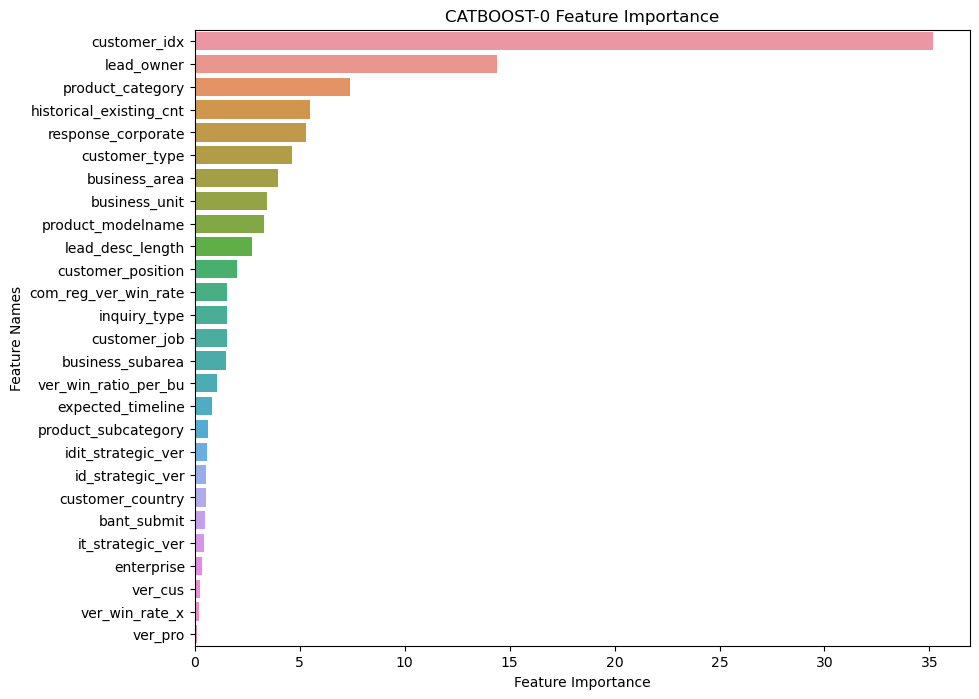

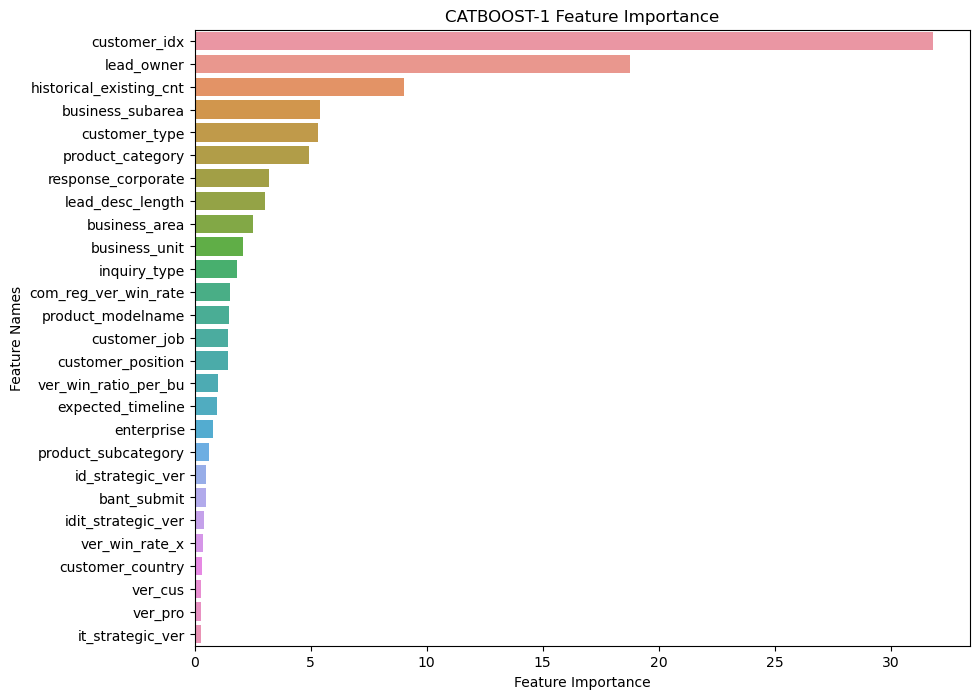

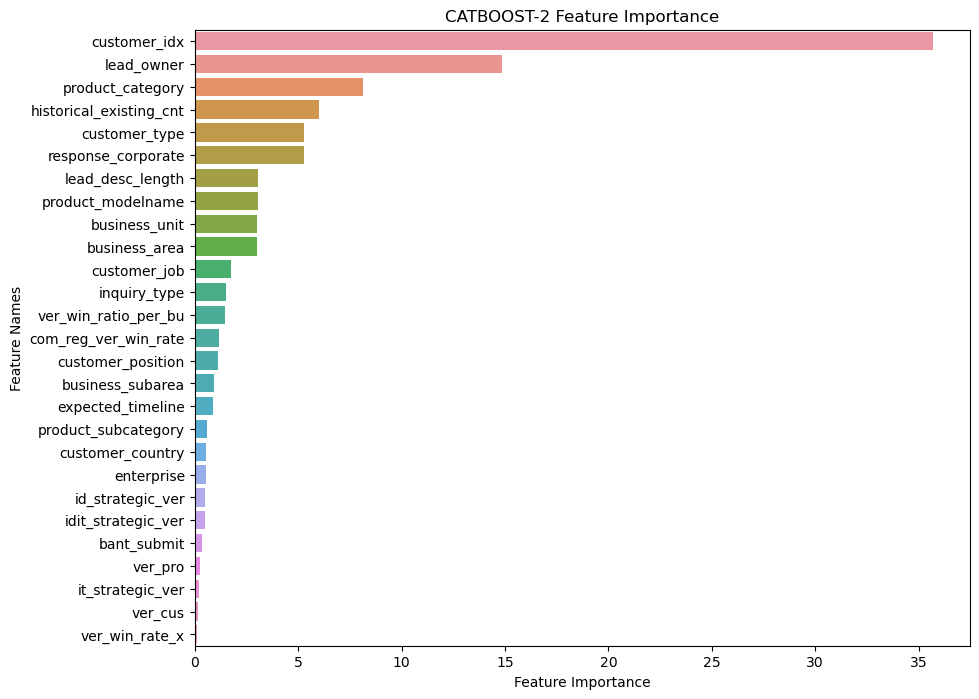

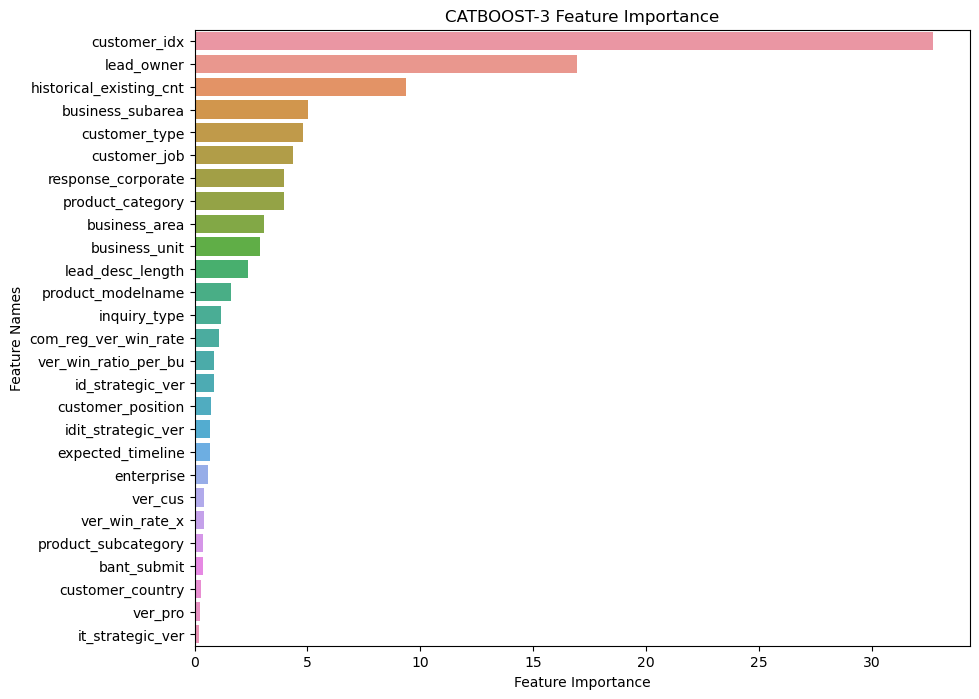

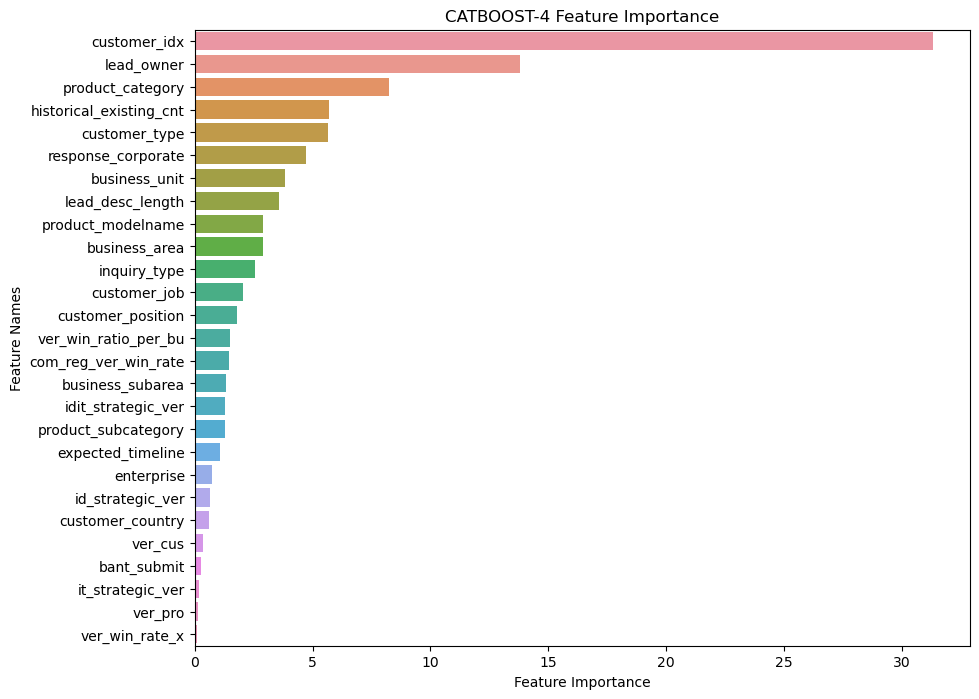

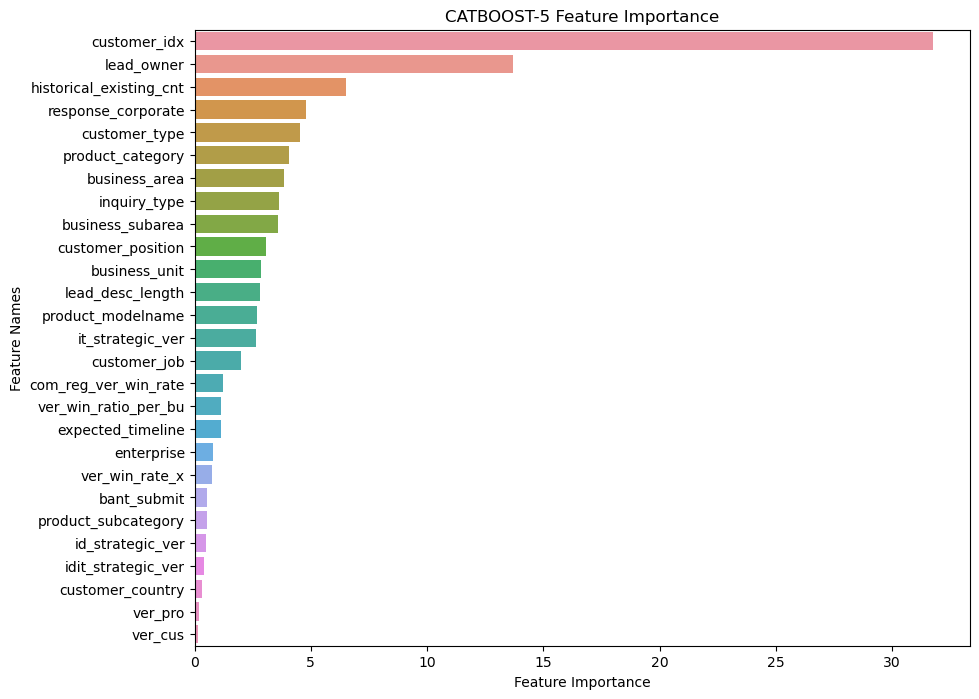

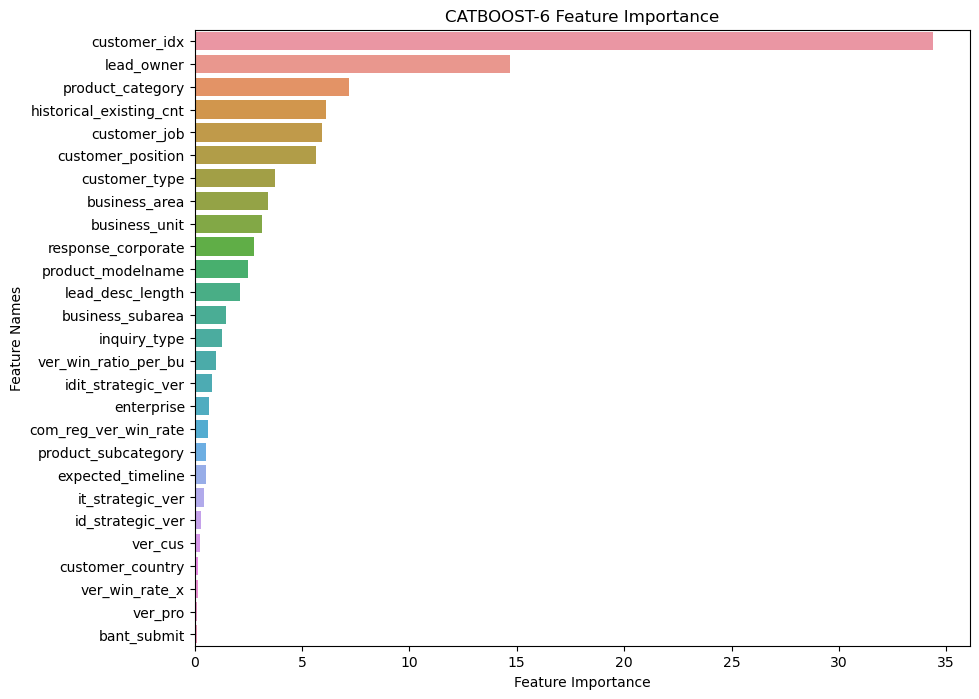

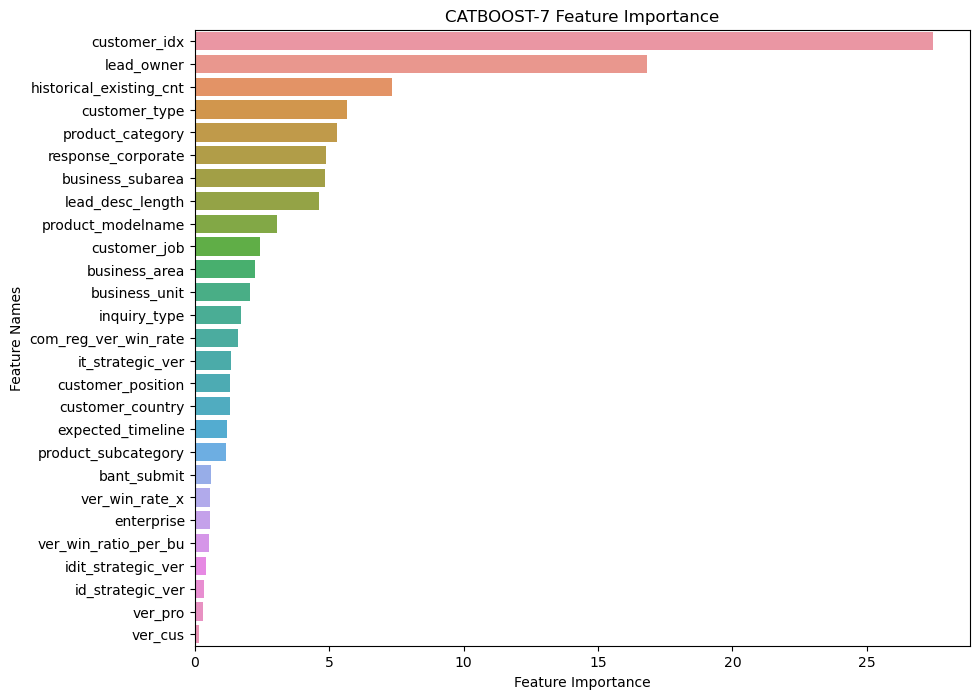

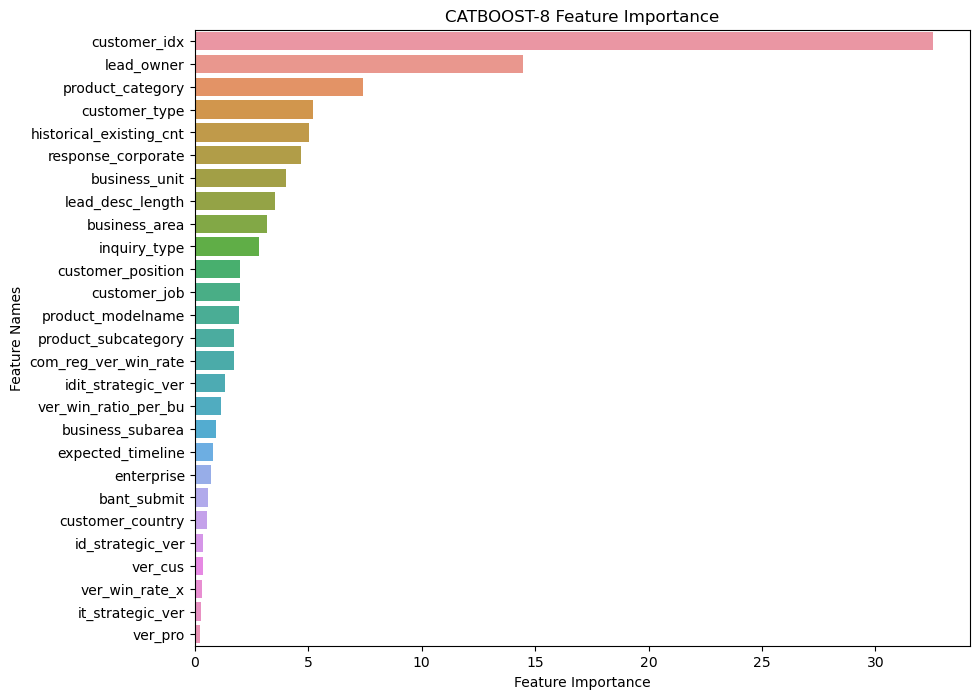

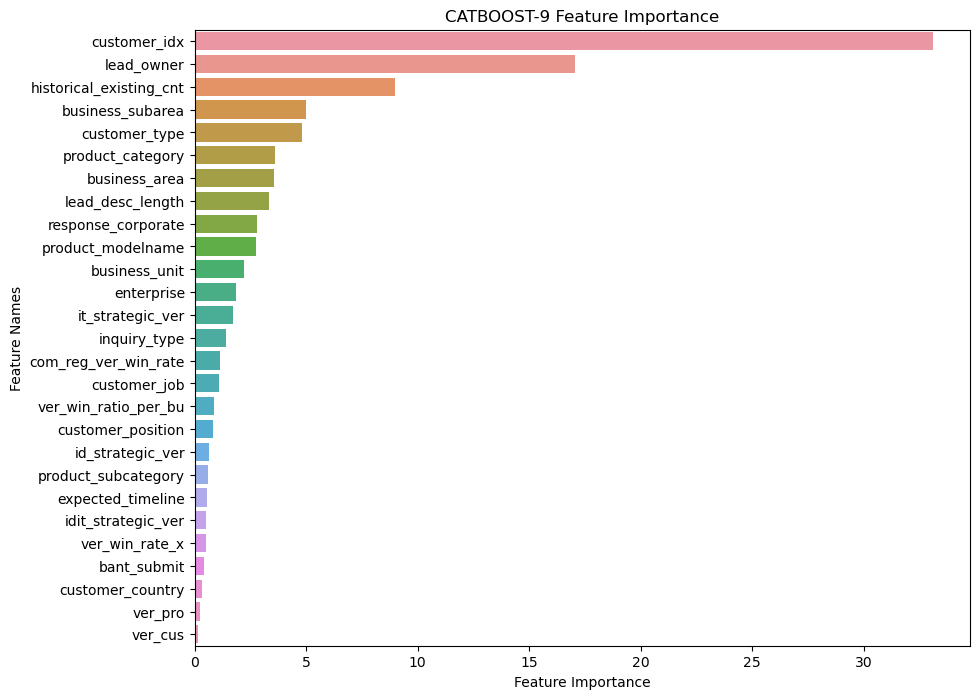

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
for i in range(10):
    plot_feature_importance(best_models[i].get_feature_importance(),df_test.drop(['is_converted','id'],axis=1).columns,f'CATBOOST-{i}')

In [37]:
train_pred = np.mean([best_model.predict_proba(df_train.drop("is_converted",axis=1)) for best_model in best_models], axis=0)
y = list(df_train['is_converted'])
threshold = min([num[1] if y[i] else 1 for i, num in enumerate(train_pred)])
train_y_pred = [True if i[1]>=0.5 else False for i in train_pred]
get_clf_eval(y, train_y_pred)

오차행렬:
 [[ 4613     7]
 [  529 50631]]

정확도: 0.9904
정밀도: 0.8971
재현율: 0.9985
F1: 0.9451


In [38]:
# all_train_pool = []
# all_val_pool = []
# all_y_val = []
for i in range(10):
    train_pred = np.mean([best_model.predict_proba(all_val_pool[i]) for best_model in best_models], axis=0)
    train_pred = np.argmax(train_pred, axis=1)
    get_clf_eval(all_y_val[i], train_pred)

오차행렬:
 [[ 462    0]
 [  66 5050]]

정확도: 0.9882
정밀도: 0.8750
재현율: 1.0000
F1: 0.9333
오차행렬:
 [[ 461    1]
 [  51 5065]]

정확도: 0.9907
정밀도: 0.9004
재현율: 0.9978
F1: 0.9466
오차행렬:
 [[ 462    0]
 [  53 5063]]

정확도: 0.9905
정밀도: 0.8971
재현율: 1.0000
F1: 0.9458
오차행렬:
 [[ 462    0]
 [  52 5064]]

정확도: 0.9907
정밀도: 0.8988
재현율: 1.0000
F1: 0.9467
오차행렬:
 [[ 461    1]
 [  49 5067]]

정확도: 0.9910
정밀도: 0.9039
재현율: 0.9978
F1: 0.9486
오차행렬:
 [[ 460    2]
 [  38 5078]]

정확도: 0.9928
정밀도: 0.9237
재현율: 0.9957
F1: 0.9583
오차행렬:
 [[ 462    0]
 [  53 5063]]

정확도: 0.9905
정밀도: 0.8971
재현율: 1.0000
F1: 0.9458
오차행렬:
 [[ 462    0]
 [  57 5059]]

정확도: 0.9898
정밀도: 0.8902
재현율: 1.0000
F1: 0.9419
오차행렬:
 [[ 459    3]
 [  60 5056]]

정확도: 0.9887
정밀도: 0.8844
재현율: 0.9935
F1: 0.9358
오차행렬:
 [[ 462    0]
 [  50 5066]]

정확도: 0.9910
정밀도: 0.9023
재현율: 1.0000
F1: 0.9487
